### General information

There are many frameworks for Deep Learning. Recently I started using Pytorch and liked it, but sometimes it requires too much coding, so I started looking for wrappers over Pytorch.

Recently a new library emerged: Kekas https://github.com/belskikh/kekas

It provides a simple API for training neural nets for images and good visualizations of training process. There are also nice tricks from fast.ai - learning rate finder, one cycle policy and others.

In this kernel I'll show what this library can do. At first I'll take a small subset of data and demonstrate the general functionality, after this we'll try training model on the full data.  Sadly, kaggle kernels have some problems currently, so I won't be able to show everything.


In [1]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from sklearn.metrics import accuracy_score
import cv2

Some of good libraries for DL aren't available in Docker with GPU by default, so it is necessary to install them. (don't forget to turn on internet connection in kernels).

In [2]:
!pip install albumentations > /dev/null 2>&1
!pip install pretrainedmodels > /dev/null 2>&1
!pip install kekas > /dev/null 2>&1
!pip install adabound > /dev/null 2>&1

In [3]:
# more imports
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import adabound

from kekas import Keker, DataOwner, DataKek
from kekas.transformations import Transformer, to_torch, normalize
from kekas.metrics import accuracy
from kekas.modules import Flatten, AdaptiveConcatPool2d
from kekas.callbacks import Callback, Callbacks, DebuggerCallback
from kekas.utils import DotDict

## Preparing data

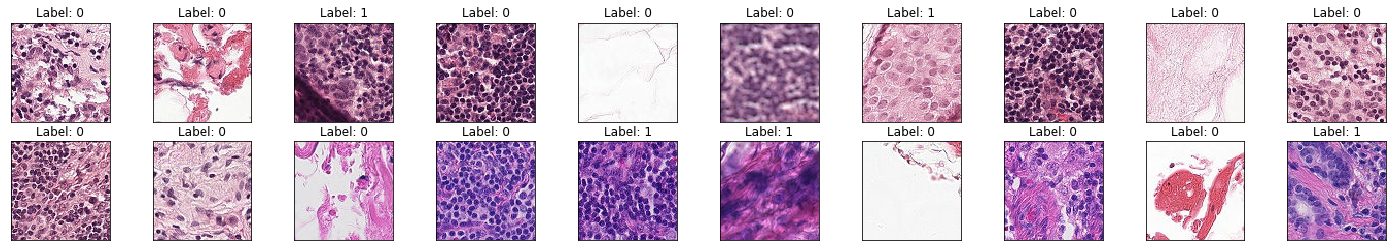

In [4]:
labels = pd.read_csv('../input/train_labels.csv')
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("../input/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

Kekas accepts pandas DataFrame as an input and iterates over it to get image names and labels

In [5]:
test_img = os.listdir('../input/test/')
test_df = pd.DataFrame(test_img, columns=['id'])
test_df['label'] = -1
test_df['data_type'] = 'test'
test_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])

labels['label'] = labels['label'].astype(int)
labels['data_type'] = 'train'

labels.head()

id  label data_type
0  f38a6374c348f90b587e046aac6079959adf3835      0     train
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1     train
2  755db6279dae599ebb4d39a9123cce439965282d      0     train
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0     train
4  068aba587a4950175d04c680d38943fd488d6a9d      0     train

In [6]:
labels.shape, test_df.shape

((220025, 3), (57458, 3))

For now let's take a subset of data for faster training.

In [7]:
train_short, _ = train_test_split(labels, stratify=labels.label, test_size=0.95)

In [8]:
train_short.shape

(11001, 3)

In [9]:
# splitting data into train and validation
train, valid = train_test_split(train_short, stratify=train_short.label, test_size=0.1)

### Reader function

At first it is necessary to create a reader function, which will open images. It accepts i and row as input (like from pandas iterrows). The function should return a dictionary with image and label.

`[:,:,::-1]` - is a neat trick which converts BGR images to RGB, it works faster that converting to RGB by usual means.

In [10]:
def reader_fn(i, row):
    image = cv2.imread(f"../input/{row['data_type']}/{row['id']}.tif")[:,:,::-1] # BGR -> RGB
    label = torch.Tensor([row["label"]])
    return {"image": image, "label": label}

### Data transformation

Next step is defining data transformations and augmentations. This differs from standard PyTorch way. We define resizing, augmentations and normalizing separately, this allows to easily create separate transformers for train and valid/test data.

At first we define augmentations. We create a function with a list of augmentations (I prefer albumentation library: https://github.com/albu/albumentations)

In [11]:
def augs(p=0.5):
    return albumentations.Compose([
        albumentations.HorizontalFlip(),
        albumentations.RandomRotate90(),
        albumentations.Transpose(),
        albumentations.Flip(),
    ], p=p)

Now we create a transforming function. It heavily uses Transformer from kekas.
* The first step is defining resizing. You can change arguments of function if you want images to have different height and width, otherwis you can leave it as it is.
* Next step is defining atgmentations. Here we provide the key of image which is defined in `reader_fn`;
* The third step is defining final transformation to tensor and normalizing;
* After this we can compose separate transformations for train and valid/test data;

In [12]:
def get_transforms(dataset_key, size, p):

    PRE_TFMS = Transformer(dataset_key, lambda x: cv2.resize(x, (size, size)))

    AUGS = Transformer(dataset_key, lambda x: augs()(image=x)["image"])

    NRM_TFMS = transforms.Compose([
        Transformer(dataset_key, to_torch()),
        Transformer(dataset_key, normalize())
    ])
    
    train_tfms = transforms.Compose([PRE_TFMS, AUGS, NRM_TFMS])
    val_tfms = transforms.Compose([PRE_TFMS, NRM_TFMS])
    
    return train_tfms, val_tfms

In [13]:
# getting transformations
train_tfms, val_tfms = get_transforms("image", 224, 0.5)

Now we can create a DataKek, which is similar to creating dataset in Pytorch. We define the data, reader function and transformation.Then we can define standard PyTorch DataLoader.

In [14]:
train_dk = DataKek(df=train, reader_fn=reader_fn, transforms=train_tfms)
val_dk = DataKek(df=valid, reader_fn=reader_fn, transforms=val_tfms)

batch_size = 32
workers = 0

train_dl = DataLoader(train_dk, batch_size=batch_size, num_workers=workers, shuffle=True, drop_last=True)
val_dl = DataLoader(val_dk, batch_size=batch_size, num_workers=workers, shuffle=False)

In [15]:
test_dk = DataKek(df=test_df, reader_fn=reader_fn, transforms=val_tfms)
test_dl = DataLoader(test_dk, batch_size=batch_size, num_workers=workers, shuffle=False)

## Building a neural net

Here we define the architecture of the neural net.

* Pre-trained backbone is taken from pretrainedmodels: https://github.com/Cadene/pretrained-models.pytorch Here I take `densenet169`
* We also define changes to the architecture. For example, we take off the last layer and add a custom head with `nn.Sequential`. `AdaptiveConcatPool2d` is a layer in kekas, which concats `AdaptiveMaxPooling` and `AdaptiveAveragePooling` 

In [16]:
# create a simple neural network using pretrainedmodels library
# https://github.com/Cadene/pretrained-models.pytorch

class Net(nn.Module):
    def __init__(
            self,
            num_classes: int,
            p: float = 0.2,
            pooling_size: int = 2,
            last_conv_size: int = 81536,
            arch: str = "densenet169",
            pretrained: str = "imagenet") -> None:
        """A simple model to finetune.
        
        Args:
            num_classes: the number of target classes, the size of the last layer's output
            p: dropout probability
            pooling_size: the size of the result feature map after adaptive pooling layer
            last_conv_size: size of the flatten last backbone conv layer
            arch: the name of the architecture form pretrainedmodels
            pretrained: the mode for pretrained model from pretrainedmodels
        """
        super().__init__()
        net = pretrainedmodels.__dict__[arch](pretrained=pretrained)
        modules = list(net.children())[:-1]  # delete last layer
        # add custom head
        modules += [nn.Sequential(
            # AdaptiveConcatPool2d is a concat of AdaptiveMaxPooling and AdaptiveAveragePooling 
            AdaptiveConcatPool2d(size=pooling_size),
            Flatten(),
            nn.BatchNorm1d(13312),
            nn.Dropout(p),
            nn.Linear(13312, num_classes)
        )]
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        logits = self.net(x)
        return logits

The data for training needs to be transformed one more time - we define DataOwner, which contains all the data. For now let's define it for train and valid.

In [17]:
dataowner = DataOwner(train_dl, val_dl, None)

Next we define model and loss. As I choose `BCEWithLogitsLoss`, we can set the number of classes for output to 1.

In [18]:
model = Net(num_classes=1)

criterion = nn.BCEWithLogitsLoss()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet169-f470b90a4.pth" to /tmp/.torch/models/densenet169-f470b90a4.pth
57372314it [00:03, 14739689.38it/s]


And now we define what will the model do with the data. For example we could slice the output and take only a part of it. For now we will simply return the output of the model.

In [19]:
def step_fn(model: torch.nn.Module,
            batch: torch.Tensor) -> torch.Tensor:
    """Determine what your model will do with your data.

    Args:
        model: the pytorch module to pass input in
        batch: the batch of data from the DataLoader

    Returns:
        The models forward pass results
    """
    
    inp = batch["image"]
    return model(inp)

### Defining custom metrics

Currently Kekas has only simple accuracy (see here: https://github.com/belskikh/kekas/blob/9f9fbb00ded7e12e79ba3d2edaa3a8f82b368722/kekas/metrics.py), but we can define any metric we like. It should accept tensors of target and prediction as an imput and return the metric value as an output.

Let's define an accuracy for out net with BCE.

In [20]:
def bce_accuracy(target: torch.Tensor,
                 preds: torch.Tensor) -> float:
    thresh = 0.5
    target = target.cpu().detach().numpy()
    preds = (torch.sigmoid(preds).cpu().detach().numpy() > thresh).astype(int)
    return accuracy_score(target, preds)

## Keker

Now we can define the Keker - the core Kekas class for training the model.

Here we define everything which is necessary for training:
* the model which was defined earlier;
* dataowner containing the data for training and validation;
* criterion;
* step function;
* the key of labels, which was defined in the reader function;
* the dictionary with metrics (there can be several of them);
* The optimizer and its parameters;

There are more advanced parameters, you can read more about them in the docstring: https://github.com/belskikh/kekas/blob/9f9fbb00ded7e12e79ba3d2edaa3a8f82b368722/kekas/keker.py

In [21]:
keker = Keker(model=model,
              dataowner=dataowner,
              criterion=criterion,
              step_fn=step_fn,
              target_key="label",
              metrics={"acc": bce_accuracy},
              opt=torch.optim.SGD,
              opt_params={"momentum": 0.99})

### Freezing and unfreezing
Freezing and unfreezing layers is quite important if you want to achieve high score. It can be done easily with Kekas. Af first you unfreeze the model and then freeze up to a necessary layer.

In [22]:
keker.unfreeze(model_attr="net")

# If you want to freeze till some layer:
layer_num = -1
keker.freeze_to(layer_num, model_attr="net")

## Various ways to train a model

### Learning Rate Find
In fast.ai Jeremy offered and idea of learning rate finder to find an optimal learning rate. Let's do it! We can simply define the final LR and the directory where logs are written.

In [23]:
keker.kek_lr(final_lr=0.001, logdir="logs")

Epoch 1/1: 100% 309/309 [01:23<00:00,  3.77it/s, loss=0.5610]
End of LRFinder



One of the ways to plot the training curves is to use tensorboard. Sadly it isn't supported well by kaggle. If you are in edit mode, you can try the next cell. Or you can simply use the keker method to plot the logs from the defined directory.

In [24]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# LOG_DIR = 'logs' # Here you have to put your log directory
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )
# get_ipython().system_raw('./ngrok http 6006 &')
# ! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
#!tensorboard --logdir logs --host 0.0.0.0 --port 6007

In [25]:
keker.plot_kek_lr('logs')

### Training the model

In [26]:
# simply training the model with pre-defined parameters.
keker.kek(lr=2e-5, epochs=1, logdir='train_logs0')

Epoch 1/1: 100% 309/309 [01:22<00:00,  3.97it/s, loss=0.3771, val_loss=0.3152, acc=0.8609]


In [27]:
# we plot all three graphs by default, but we can also choose which of them will be shown.
keker.plot_kek('train_logs0', metrics=['loss', 'acc'])

Also we can define new parameters or even override old ones.

In [28]:
keker.kek(lr=2e-5, epochs=3,
         sched=torch.optim.lr_scheduler.StepLR,
              sched_params={"step_size":1, "gamma": 0.9},# optimizer class. if note specifiyng, 
                                                  # an SGD is using by default
              opt_params={"weight_decay": 1e-5},
              early_stop_params={
              "patience": 2,   
              "metric": "acc", 
              "mode": "min",   
              "min_delta": 0
          }, logdir='train_logs')

Epoch 1/3: 100% 309/309 [01:20<00:00,  4.13it/s, loss=0.3513, val_loss=0.3167, acc=0.8600]
Epoch 2/3: 100% 309/309 [01:20<00:00,  4.12it/s, loss=0.3662, val_loss=0.3100, acc=0.8622]
Epoch 3/3: 100% 309/309 [01:20<00:00,  4.13it/s, loss=0.3911, val_loss=0.3246, acc=0.8519]


In [29]:
keker.plot_kek('train_logs')

One more cool feature is a possibility to use one cycle!

In [30]:
keker.kek_one_cycle(max_lr=1e-4,                  # the maximum learning rate
                    cycle_len=3,                  # number of epochs, actually, but not exactly
                    momentum_range=(0.95, 0.85),  # range of momentum changes
                    div_factor=25,                # max_lr / min_lr
                    increase_fraction=0.3,        # the part of cycle when learning rate increases
                    logdir='train_logs1')

Epoch 1/3: 100% 309/309 [01:20<00:00,  4.08it/s, loss=0.3310, val_loss=0.2962, acc=0.8702]
Epoch 2/3: 100% 309/309 [01:20<00:00,  4.10it/s, loss=0.3594, val_loss=0.2992, acc=0.8742]
Epoch 3/3: 100% 309/309 [01:20<00:00,  4.16it/s, loss=0.3740, val_loss=0.2790, acc=0.8880]


In [31]:
keker.plot_kek('train_logs1')

There are much more features, you can read the tutorial: https://github.com/belskikh/kekas/blob/master/Tutorial.ipynb or the code itself

## Training model on all data

Now, let's train model on all data.

I use AdaBound: https://github.com/Luolc/AdaBound

In [32]:
train, valid = train_test_split(labels, stratify=labels.label, test_size=0.1)

train_dk = DataKek(df=train, reader_fn=reader_fn, transforms=train_tfms)
val_dk = DataKek(df=valid, reader_fn=reader_fn, transforms=val_tfms)

train_dl = DataLoader(train_dk, batch_size=batch_size, num_workers=workers, shuffle=True, drop_last=True)
val_dl = DataLoader(val_dk, batch_size=batch_size, num_workers=workers, shuffle=False)

test_dk = DataKek(df=test_df, reader_fn=reader_fn, transforms=val_tfms)
test_dl = DataLoader(test_dk, batch_size=batch_size, num_workers=workers, shuffle=False)

dataowner = DataOwner(train_dl, val_dl, None)

keker = Keker(model=model,
              dataowner=dataowner,
              criterion=criterion,
              step_fn=step_fn,
              target_key="label",
              metrics={"acc": bce_accuracy},
              opt=adabound.AdaBound,
              opt_params={'final_lr': 0.001})

keker.unfreeze(model_attr="net")

layer_num = -3
keker.freeze_to(layer_num, model_attr="net")

In [33]:
keker.kek_one_cycle(max_lr=1e-4,
                    cycle_len=6,
                    momentum_range=(0.95, 0.85),
                    div_factor=25,
                    increase_fraction=0.3)

Epoch 1/6:  51% 3173/6188 [19:39<18:45,  2.68it/s, loss=0.2798]

In [ ]:
# keker.kek(lr=2e-5, epochs=3,
#          sched=ReduceLROnPlateau,
#               sched_params={"patience":2, "factor": 0.1},# optimizer class. if note specifiyng, 
#                                                   # an SGD is using by default
#               early_stop_params={
#               "patience": 2,   
#               "metric": "acc", 
#               "mode": "min",   
#               "min_delta": 0
#           }, logdir='train_logs_fin')

In [ ]:
keker.plot_kek_lr('train_logs_fin')

## Predicting and TTA

Simply predicting on test data is okay, but it is better to use TTA - test time augmentation. Let's see how it can be done with Kekas.

* define augmentations;
* define augmentation function;
* create objects with these augmentations;
* put these objects into a single dictionary;

In [ ]:
# simple prediction
preds = keker.predict_loader(loader=test_dl)

In [ ]:
# TTA
flip_ = albumentations.Flip(always_apply=True)
transpose_ = albumentations.Transpose(always_apply=True)

def insert_aug(aug, dataset_key="image", size=224):    
    PRE_TFMS = Transformer(dataset_key, lambda x: cv2.resize(x, (size, size)))
    
    AUGS = Transformer(dataset_key, lambda x: aug(image=x)["image"])
    
    NRM_TFMS = transforms.Compose([
        Transformer(dataset_key, to_torch()),
        Transformer(dataset_key, normalize())
    ])
    
    tfm = transforms.Compose([PRE_TFMS, AUGS, NRM_TFMS])
    return tfm

flip = insert_aug(flip_)
transpose = insert_aug(transpose_)

tta_tfms = {"flip": flip, "transpose": transpose}

# third, run TTA
keker.TTA(loader=test_dl,                # loader to predict on 
          tfms=tta_tfms,                # list or dict of always applying transforms
          savedir="tta_preds1",  # savedir
          prefix="preds")               # (optional) name prefix. default is 'preds'

# it will saves predicts for each augmentation to savedir with name
#  - {prefix}_{name_from_dict}.npy if tfms is a dict
#  - {prefix}_{index}.npy          if tfms is a list

In [ ]:
prediction = np.zeros((test_df.shape[0], 1))
for i in os.listdir('tta_preds1'):
    pr = np.load('tta_preds1/' + i)
    prediction += pr
try:
    prediction = prediction / len(os.listdir('tta_preds1'))
except:
    pass

In [ ]:
test_preds = pd.DataFrame({'imgs': test_df.id.values, 'preds': prediction.reshape(-1,)})
test_preds.columns = ['id', 'label']
test_preds.to_csv('sub.csv', index=False)